In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from typing import Union
import pandas as pd
import numpy as np

In [2]:
ModelRegressor = Union[RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, LogisticRegression]

In [3]:
def dummy_fit_predict(classifier: ModelRegressor, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame) -> tuple():
    if X_train.empty or X_test.empty or y_train.empty:
        raise ValueError("Empty set passed!")
    
    classifier.fit(X_train, np.ravel(y_train))
    pred_train = classifier.predict_proba(X_train)
    pred_test = classifier.predict_proba(X_test.fillna(0))

    return pred_train, pred_test


In [4]:
def dummy_roc_auc_score(y_true: np.ndarray, y_score: np.ndarray) -> np.float64:
    return roc_auc_score(y_true, y_score[:, 1])

<h1> 1. Wczytanie przetworzonych zbiorow danych z Lab3. </h1>

In [5]:
X_train = pd.read_csv('X_train.csv', usecols = [i for i in range(1,7)])
X_test = pd.read_csv('X_test.csv', usecols = [i for i in range(1,7)])
y_train = pd.read_csv('y_train.csv', usecols = [1])
y_test = pd.read_csv('y_test.csv', usecols = [1])

In [6]:
X_train.head(10)

,sex,cabin,CabinReduced,sex_mapped,cabin_mapped,CabinReduced_mapped
0,female,NaN,NaN,0,0,0
1,female,NaN,NaN,0,0,0
2,female,NaN,NaN,0,0,0
3,male,NaN,NaN,1,0,0
4,female,NaN,NaN,0,0,0
5,male,NaN,NaN,1,0,0
6,female,E36,E,0,1,1
7,female,NaN,NaN,0,0,0
8,male,C68,C,1,2,2
9,male,E24,E,1,3,1


<h1> 2. Uzycie algorytmu Random Forests </h1>

In [ ]:
RF = RandomForestClassifier(n_estimators = 200, random_state = 42)

<h2> 2.1 Dla danych o wysokiej liczebnosci cech. </h2>

In [7]:
pred_train, pred_test = dummy_fit_predict(RF, X_train[['sex_mapped', 'cabin_mapped']], X_test[['sex_mapped', 'cabin_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

Wynik dla zbioru treningowego: 0.8541, wynik dla zbioru testowego: 0.7608


<h2> 2.2 Dla danych o niskiej liczebnosci cech.

In [8]:
pred_train, pred_test = dummy_fit_predict(RF, X_train[['sex_mapped', 'CabinReduced_mapped']], X_test[['sex_mapped', 'CabinReduced_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

Wynik dla zbioru treningowego: 0.8164, wynik dla zbioru testowego: 0.8017


<h1> 3. Uzycie algorytmu Logistic Regression. </h1>

In [ ]:
LR = LogisticRegression(random_state = 42, max_iter = 1000)

<h2> 3.1 Dla danych o wysokiej liczebnosci cech.

In [9]:
pred_train, pred_test = dummy_fit_predict(LR, X_train[['sex_mapped', 'cabin_mapped']], X_test[['sex_mapped', 'cabin_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

Wynik dla zbioru treningowego: 0.8136, wynik dla zbioru testowego: 0.7821


<h2> 3.2 Dla danych o niskiej liczebnosci cech. </h2>

In [10]:
pred_train, pred_test = dummy_fit_predict(LR, X_train[['sex_mapped', 'CabinReduced_mapped']], X_test[['sex_mapped', 'CabinReduced_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

Wynik dla zbioru treningowego: 0.8123, wynik dla zbioru testowego: 0.8008


<h1> 4. Uzycie algorytmu GradientBoostingClassifier </h1>

In [19]:
GBC = GradientBoostingClassifier(n_estimators = 220, random_state = 42)

<h2> 4.1 Dla danych o wysokiej liczebnosci cech.

In [20]:
pred_train, pred_test = dummy_fit_predict(GBC, X_train[['sex_mapped', 'cabin_mapped']], X_test[['sex_mapped', 'cabin_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

Wynik dla zbioru treningowego: 0.8600, wynik dla zbioru testowego: 0.7641


<h2> 4.2 Dla danych o niskiej liczebnosci cech. </h2>

In [21]:
pred_train, pred_test = dummy_fit_predict(GBC, X_train[['sex_mapped', 'CabinReduced_mapped']], X_test[['sex_mapped', 'CabinReduced_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

Wynik dla zbioru treningowego: 0.8167, wynik dla zbioru testowego: 0.8015


<h1> 5. Uzycie algorytmu AdaBoostClassifier </h1>

In [22]:
ABC = AdaBoostClassifier(n_estimators = 220, random_state = 42)

<h2> 5.1 Dla danych o wysokiej liczebnosci cech. </h2>

In [24]:
pred_train, pred_test = dummy_fit_predict(ABC, X_train[['sex_mapped', 'cabin_mapped']], X_test[['sex_mapped', 'cabin_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

Wynik dla zbioru treningowego: 0.8299, wynik dla zbioru testowego: 0.7645


<h2> 5.2 Dla danych o niskiej liczebnosci cech </h2>

In [25]:
pred_train, pred_test = dummy_fit_predict(ABC, X_train[['sex_mapped', 'CabinReduced_mapped']], X_test[['sex_mapped', 'CabinReduced_mapped']], y_train)

print(f'Wynik dla zbioru treningowego: {dummy_roc_auc_score(y_train, pred_train):.4f}, wynik dla zbioru testowego: {dummy_roc_auc_score(y_test, pred_test):.4f}')

Wynik dla zbioru treningowego: 0.8161, wynik dla zbioru testowego: 0.8001


<h1> 6. Analiza przeprowadzonych badan </h1> 

<h1> 7. Predict vs predict_proba </h1>

In [11]:
y_pred = np.argmax(pred_test, axis = 1)

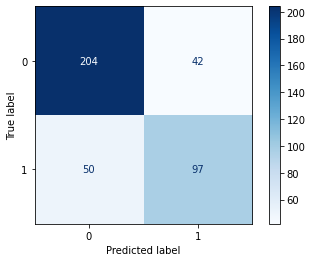

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.show()

Confusion matrix, without normalization
[[207  39]
 [ 49  98]]
Normalized confusion matrix
[[0.84 0.16]
 [0.33 0.67]]


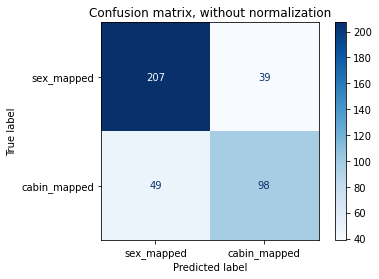

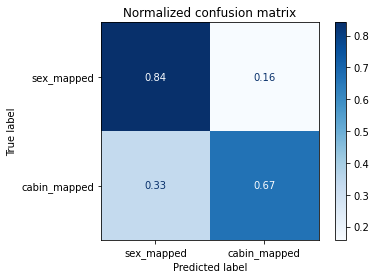

In [14]:
np.set_printoptions(precision=2)
class_names = ['sex_mapped', 'cabin_mapped']
classifier = RF.fit(X_train[['sex_mapped', 'cabin_mapped']], np.ravel(y_train))

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test[['sex_mapped', 'cabin_mapped']],
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
